In [70]:
import pandas as pd
import numpy as np

In [2]:
from importlib.machinery import SourceFileLoader

tools = SourceFileLoader("tools", "../tools.py").load_module()

from tools import write_to_file

In [3]:
import matplotlib
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['legend.numpoints'] = 1

%matplotlib inline

In [4]:
font = {"size": 10, "weight": "bold"}
matplotlib.rc("font", **font)

General & Temporial Analysis
===================

In [5]:
df = pd.read_csv("../data/prisoners_dilemma_articles_meta_data_clean.csv")

In [6]:
df = df.replace("None", np.nan)

In [7]:
label = 'prisoners_dilemma'

**Total number of articles.**

In [8]:
total_articles = len(df["title"].unique())


**Unique titles**

In [9]:
len(df["title"].unique()), len(df["unique_key"].unique())


(2422, 2470)

**Numbers of author and year range.**

In [11]:
number_of_authors = len(df["author"].unique())
number_of_authors

4226

In [12]:
for data, name in zip(
    [total_articles, number_of_authors],
    ["total_articles.txt", "number_of_authors.txt"]
):
    write_to_file(metric=data, filename=name)


Provenance
----------

The total number of articles is given above. Here we can illustrate the provenance of these articles.
Thus we can see from which journal they have been collected and how many articles have been added by us. The table below shows the number of articles for each provenance.

In [10]:
provenance_size = (
    df.groupby(["unique_key", "provenance"])
    .size()
    .reset_index()
    .groupby("provenance")
    .size()
)

In [11]:
provenance_size

provenance
IEEE        294
Manual       76
Nature      436
PLOS        477
Springer    533
arXiv       654
dtype: int64

In [12]:
write_to_file(metric=provenance_size["Manual"], filename="prov_manual.txt")

In [13]:
percentages = provenance_size.apply(lambda x: round(x / total_articles * 100, 2))


In [14]:
provenance_tables = []

provenance_table = pd.concat([provenance_size, percentages], axis=1)
provenance_table.columns = ["Number of Articles", "Percentage"]
provenance_tables.append(provenance_table)

In [15]:
provenance_table

,Number of Articles,Percentage
provenance,,
IEEE,294,12.14
Manual,76,3.14
Nature,436,18.00
PLOS,477,19.69
Springer,533,22.01
arXiv,654,27.00


In [16]:
# write_to_file(metric=provenance_table.to_latex().replace(' \\\\\n', '\%\\\\\n').replace(' \%\\\\\n', ' \\\\\n')
#               , filename="provenance_table.tex")


Temporal Analysis
-----------------

In [17]:
color = 'midnightblue'

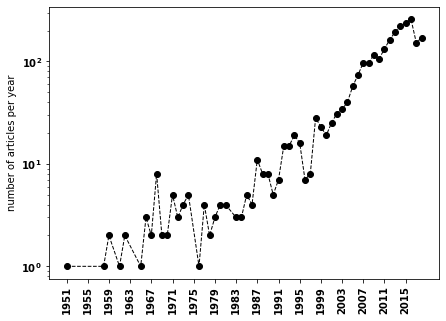

In [19]:
total = len(df["unique_key"].unique())

yearly = (
    df.groupby(["unique_key", "date"]).size().reset_index().groupby("date").size()
)

fig, axes = plt.subplots(figsize=(7, 5))

plt.plot(yearly.index, yearly.values, "--o", zorder=1, linewidth=1, color='black')
plt.xticks(np.arange(min(yearly.index), 2018, step=4), rotation=90)

plt.ylabel("number of articles per year")

axes.set_yscale('log')

plt.savefig("../../assets/images/timeline.pdf",
                bbox_inches="tight")

In [20]:
yearly_provenances = (
    df.groupby(["unique_key", "provenance", "date"])
    .size()
    .reset_index()
    .groupby(["provenance", "date"])
    .size()
)


In [21]:
yearly_df = (
    df.groupby(["unique_key", "date"]).size().reset_index().groupby("date").size()
)


**Fitting and forecasting**

In [22]:
colors

UsageError: %colors: you must specify a color scheme. See '%colors?'


In [23]:
from scipy import optimize


def func(x, a, b, c):
    return a * np.exp(-b * np.array(x)) + c

In [24]:
y = yearly_df[:2016].values
x = [i for i,_ in enumerate(y)]

params, params_covariance = optimize.curve_fit(func, x, y, p0=[0, 0, 0])

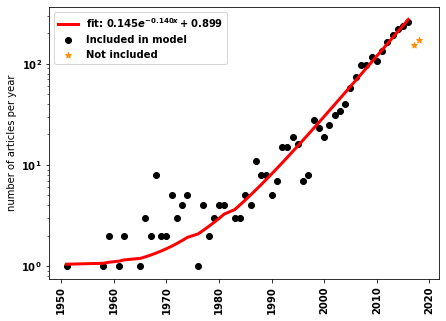

In [31]:
fig, axes = plt.subplots(figsize=(7, 5))

plt.scatter(
    yearly_df[:2016].index,
    y,
    zorder=1,
    linewidth=1,
    label="Included in model",
    color='black'
)
plt.plot(
    yearly_df[:2016].index,
    func(x, params[0], params[1], params[2]),
    label=r"fit: $ %5.3f e^{%5.3f x} +%5.3f$" % tuple(params),
    color="red",
    zorder=2,
    linewidth=3,
)
plt.scatter(
    yearly_df[2017:2018].index,
    yearly_df[2017:2018].values,
    zorder=1,
    linewidth=1,
    marker="*",
    label="Not included",
    color='darkorange'
)
plt.xticks(rotation=90)
plt.legend(loc="best")

plt.ylabel("number of articles per year")
axes.set_yscale('log')
plt.savefig("../../assets/images/fitting.pdf", bbox_inches="tight")


In [26]:
len(yearly_df[:2016].index,)

55

In [27]:
xn = range(55, 60)


In [28]:
forecasting = [round(func(x_v, *params)) for x_v in xn]


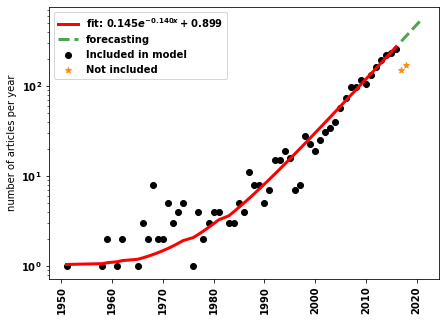

In [30]:
fig, axes = plt.subplots(figsize=(7, 5))
plt.scatter(
    yearly_df[:2016].index,
    y,
    zorder=1,
    linewidth=1,
    label="Included in model",
    color='black'
)
plt.plot(
    yearly_df[:2016].index,
    func(x, params[0], params[1], params[2]),
    label=r"fit: $ %5.3f e^{%5.3f x} +%5.3f$" % tuple(params),
    color="red",
    zorder=2,
    linewidth=3,
)
plt.plot(
    range(2017, 2022),
    forecasting,
    label="forecasting",
    color="green",
    zorder=2,
    linewidth=3,
    alpha=0.7,
    linestyle="--",
)
plt.scatter(
    yearly_df[2017:2018].index,
    yearly_df[2017:2018].values,
    zorder=1,
    linewidth=1,
    marker="*",
    label="Not included",
    color='darkorange'
)

plt.xticks(rotation=90)

plt.legend(loc="best")

plt.ylabel("number of articles per year")
axes.set_yscale('log')
plt.savefig("../../assets/images/forecasting.pdf", bbox_inches="tight")


**First publications per Journal**

In [37]:
min_years_table = {}
for provenance in df['provenance'].unique():
    year = min(df[df['provenance'] == provenance].date)
    min_years_table[provenance] = year

In [38]:
min_years = pd.DataFrame.from_dict(min_years_table, orient='index', columns=['Year of fist publication'])

In [71]:
max_years_table = {}
for provenance in df['provenance'].unique():
    year = max(df[df['provenance'] == provenance].date)
    max_years_table[provenance] = year

In [72]:
max_years_table

{'Springer': 2018.0,
 'Nature': 2018.0,
 'PLOS': 2018.0,
 'IEEE': 2018.0,
 'arXiv': 2018.0,
 'Manual': 2018.0}

Av. publication
------

The rate is calculated as the ratio of number of total articles and the number of years of publication.
Thus:
    $$ \text{rate}= \frac{\text{number of articles}}{\text{years of publication}}$$

In [39]:
(yearly_df.values.sum() / yearly_df.count())


43.31578947368421

In [40]:
rates = [np.round(yearly_df.values.sum() / yearly_df.count())]
apis = ["IEEE", "Nature", "PLOS", "Springer", "arXiv", "Manual"]
for api in apis:
    rates.append(np.round(yearly_provenances[api].values.sum() / yearly_df.count()))

rates_table = pd.DataFrame(
rates,
["Overall"] + apis,
columns={'Average number of publications'},
)


In [41]:
preliminary_table = pd.concat([provenance_table, min_years, rates_table], axis=1)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [85]:
write_to_file(metric=preliminary_table.to_latex().replace(' \\\\\n', '\%\\\\\n').replace(' \%\\\\\n', ' \\\\\n')
              , filename="preliminary_table.tex")



In [34]:
rates_table

,$\mu_p$
Overall,43.0
IEEE,5.0
Nature,8.0
PLOS,8.0
Springer,9.0
arXiv,11.0


In [34]:
write_to_file(metric=rates_table.to_latex()
              , filename="rates_table.tex")


**Collaboration Index**

In [63]:
number_of_authors_per_paper = df[['unique_key', 'author']].drop_duplicates().groupby(['unique_key']).count()
number_of_authors_per_paper.reset_index(level=0, inplace=True)

In [64]:
number_of_authors_per_paper = number_of_authors_per_paper.merge(df[['unique_key', 'date']].drop_duplicates(),
                                                                on='unique_key')

In [69]:
len(number_of_authors_per_paper[number_of_authors_per_paper['author'] == 1])

545

In [68]:
len(number_of_authors_per_paper[number_of_authors_per_paper['author'] == 1]) / total_articles

0.2250206440957886

In [61]:
number_of_authors_per_paper = number_of_authors_per_paper[number_of_authors_per_paper['author'] > 1]

In [45]:
np.mean(number_of_authors_per_paper['author'])

3.208831168831169

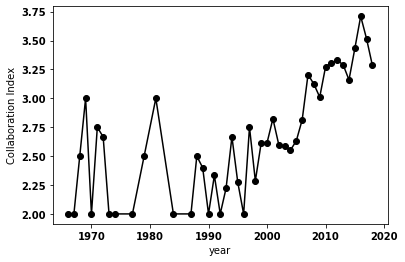

In [46]:
plt.plot(number_of_authors_per_paper.groupby('date').mean(),
         '-o', color='black');
plt.xlabel('year')
plt.ylabel('Collaboration Index');

plt.savefig("../../assets/images/collaborative_index.pdf",
            bbox_inches="tight")


In [47]:
papers_per_author = df[['author', 'unique_key']].drop_duplicates().groupby('author').count()

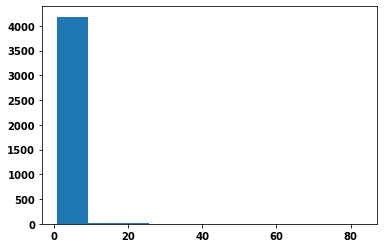

In [48]:
plt.hist(papers_per_author .values);

In [49]:
max(papers_per_author .values)

array([83])

In [50]:
papers_per_author[papers_per_author.values == 83]

,unique_key
author,
Matjaz Perc,83


In [51]:
values = df[['author', 'unique_key']].drop_duplicates().groupby('author').count().values

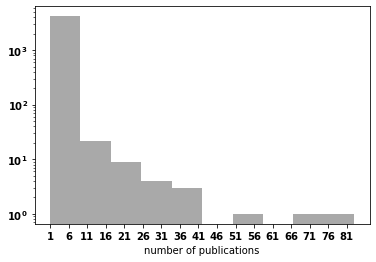

In [56]:
fig, ax = plt.subplots()

ax.hist(np.sort(values.flatten()), log=True,
        color='darkgrey');

ax.set_xlabel('number of publications');

plt.xticks(np.arange(min(values), max(values), 5.0));

plt.savefig("../../assets/images/papers_per_author.pdf",
            bbox_inches="tight")